In [2]:
import json
import os
import random

import dimod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy as sym
import torch
from dimod import SimulatedAnnealingSampler
from qubo_ml.data.utils import get_data
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [3]:
data_path = "/Path/to/data_path"
df = pd.read_csv(os.path.join(data_path, "filtered_negishi.csv"))
reagent_df = pd.read_csv(os.path.join(data_path, "filtered_negishi_reagent.csv"))
sol_df = pd.read_csv(os.path.join(data_path, "filtered_negishi_sol.csv"))

In [4]:
data = get_data(
    path=os.path.join(data_path, "filtered_negishi.csv"),
    smiles_columns=["Reaction"],
    target_columns=["Yield (numerical)"],
    features_path=None,
    features_generator=["MACCS"],
    is_reaction=True,
    reaction_mode="reac_only",
)
num_bits = data[0].features.shape[0]

5188it [00:00, 209481.01it/s]
100%|██████████| 5188/5188 [00:06<00:00, 843.20it/s] 


In [5]:
reagent_set = {f"reagent_{i}": reagent for i, reagent in enumerate(reagent_df.keys())}
sol_set = {f"sol_{i}": sol for i, sol in enumerate(sol_df.keys())}
reagents_list = [sym.symbols(f"reagent_{i}") for i in range(len(reagent_set))]
sols_list = [sym.symbols(f"sol_{i}") for i in range(len(sol_set))]

In [6]:
def get_poly(reaction_encodding, model_path):
    state = torch.load(model_path, map_location=lambda storage, loc: storage)
    loaded_state_dict = state["state_dict"]
    Q = loaded_state_dict["Q"]
    Q = np.array(Q, dtype=object)

    scaler = state["data_scaler"]
    mean = scaler["means"][0]
    std = scaler["stds"][0]

    reagents_encodding = np.array(reagents_list)
    sols_encodding = np.array(sols_list)

    x_encodding = np.append(reaction_encodding, reagents_encodding)
    x_encodding = np.append(x_encodding, sols_encodding)
    x_encodding = x_encodding.reshape(-1, 1)

    xQ = np.matmul(x_encodding.T, Q)
    xQx = np.matmul(xQ, x_encodding)
    poly = xQx[0][0].as_poly()

    # inverse the normalization back to the original scale (i.e., yield percentage)
    poly = poly * std + mean
    return poly, Q, std, mean


def get_yield(x_encodding, Qs, stds, means):
    yields = []
    for Q, std, mean in zip(Qs, stds, means):
        xQ = np.matmul(x_encodding.T, Q)
        xQx = np.matmul(xQ, x_encodding)
        y = xQx * std + mean
        yields.append(y)
    return sum(yields) / len(yields)

In [19]:
reaction_encodding = data[0].features
ensemble_size = 5
polys = []
Qs = []
stds = []
means = []

for i in tqdm(range(ensemble_size)):
    model_path = f"./models/fold_0/model_{i}/model.pt"  # change to the path accordingly
    poly, Q, std, mean = get_poly(reaction_encodding, model_path)
    polys.append(poly)
    Qs.append(Q)
    stds.append(std)
    means.append(mean)

poly = 0
for p in polys:
    poly += p
poly = poly / ensemble_size
poly = poly.as_poly()
symbols = poly.gens

100%|█████████████████████████████████████████████| 5/5 [01:59<00:00, 23.97s/it]


In [20]:
terms = poly.terms()
coeff_symbols = []
coeff_values = []
for term in terms:
    coeff, monom = term
    coeff_symbol = []
    for index, order in enumerate(coeff):
        for j in range(order):
            coeff_symbol.append(str(symbols[index]))
    coeff_symbols.append(tuple(coeff_symbol))
    coeff_values.append(monom)

## SimulatedAnnealingSampler for inferencing

In [54]:
qubo_set = {symbol: value for symbol, value in zip(coeff_symbols, coeff_values)}
bqm = dimod.make_quadratic(qubo_set, 5.0, dimod.BINARY)
bqm.add_linear_inequality_constraint(
    [(str(item), 1) for item in reagents_list], -100, label="reagent", lb=1, ub=4
)
bqm.add_linear_inequality_constraint(
    [(str(item), 1) for item in sols_list], -100, label="sol", lb=0, ub=2
)
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(-bqm, num_reads=1)
print(sampleset)
sampleset.first

  reagent_0 reagent_1 reagent_10 reagent_100 ... sol_9     energy num_oc.
0         0         0          0           0 ...     0 -64.130188       1
['BINARY', 1 rows, 1 samples, 139 variables]


Sample(sample={'reagent_0': 0, 'reagent_1': 0, 'reagent_10': 0, 'reagent_100': 0, 'reagent_101': 0, 'reagent_102': 0, 'reagent_103': 0, 'reagent_104': 0, 'reagent_105': 0, 'reagent_106': 1, 'reagent_107': 1, 'reagent_108': 0, 'reagent_109': 0, 'reagent_11': 0, 'reagent_110': 1, 'reagent_12': 0, 'reagent_13': 0, 'reagent_14': 0, 'reagent_15': 0, 'reagent_16': 0, 'reagent_17': 0, 'reagent_18': 0, 'reagent_19': 0, 'reagent_2': 0, 'reagent_20': 0, 'reagent_21': 0, 'reagent_22': 0, 'reagent_23': 0, 'reagent_24': 0, 'reagent_25': 0, 'reagent_26': 0, 'reagent_27': 0, 'reagent_28': 0, 'reagent_29': 0, 'reagent_3': 0, 'reagent_30': 0, 'reagent_31': 0, 'reagent_32': 0, 'reagent_33': 0, 'reagent_34': 0, 'reagent_35': 0, 'reagent_36': 0, 'reagent_37': 0, 'reagent_38': 0, 'reagent_39': 0, 'reagent_4': 0, 'reagent_40': 0, 'reagent_41': 0, 'reagent_42': 0, 'reagent_43': 0, 'reagent_44': 0, 'reagent_45': 0, 'reagent_46': 0, 'reagent_47': 0, 'reagent_48': 0, 'reagent_49': 0, 'reagent_5': 0, 'reagent_50

## CPU for inferencing

In [65]:
# Define the number of rows and columns
num_rows = 10**5  # You can change this to the desired number of rows
num_reagents = len(reagents_list)
num_sols = len(sols_list)

# Initialize an empty list to store selected combinations
selected_combinations = []

# Generate combinations with a limited number of ones (between 1 and 4)
for _ in range(int(num_rows * 1.5)):
    reagents_combo = [0] * num_reagents  # Initialize with all 0s
    sols_combo = [0] * num_sols  # Initialize with all 0s
    num_reagents_ones = random.randint(1, 4)  # Randomly choose the number of ones
    num_sols_ones = random.randint(0, 2)  # Randomly choose the number of ones

    # Randomly choose positions to set to 1
    reagents_ones_indices = random.sample(range(num_reagents), num_reagents_ones)
    sols_ones_indices = random.sample(range(num_sols), num_sols_ones)

    for index in reagents_ones_indices:
        reagents_combo[index] = 1
    for index in sols_ones_indices:
        sols_combo[index] = 1

    selected_combinations.append(reagents_combo + sols_combo)

# Create a dataframe from the selected combinations
df = pd.DataFrame(
    selected_combinations,
    columns=[f"reagent_{i}" for i in range(len(reagents_list))]
    + [f"sol_{i}" for i in range(len(sols_list))],
)

# Print the dataframe
df = df.drop_duplicates()
df = df[:num_rows]
df

,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,sol_14,sol_15,sol_16,sol_17,sol_18,sol_19,sol_20,sol_21,sol_22,sol_23
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126204,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126207,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
yields = []
for i in tqdm(range(len(df))):
    x_encodding = np.concatenate([reaction_encodding, df.iloc[i].tolist()])
    y = get_yield(x_encodding, Qs, stds, means)
    yields.append(y)
df["yields"] = yields

100%|███████████████████████████████████| 100000/100000 [20:33<00:00, 81.04it/s]


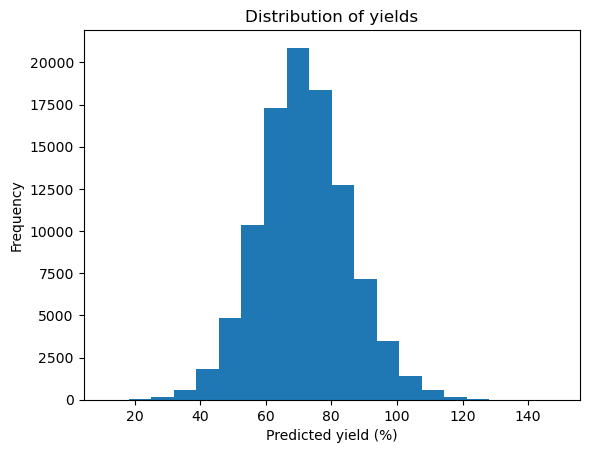

In [85]:
# Plot a histogram
plt.hist(df["yields"], bins=20)  # You can adjust the number of bins as needed
plt.xlabel("Predicted yield (%)")
plt.ylabel("Frequency")
plt.title(f"Distribution of yields")
plt.show()

In [68]:
df.to_csv("cpu_results.csv", index=False)

In [90]:
df.describe()["yields"]

count    100000.000000
mean         71.670738
std          13.747640
min          11.367348
25%          62.633304
50%          71.235154
75%          80.370633
max         148.832407
Name: yields, dtype: float64

## DAU

In [46]:
terms = poly.terms()
coeff_symbols = []
coeff_values = []
for term in terms:
    coeff, monom = term
    coeff_symbol = []
    for index, order in enumerate(coeff):
        for j in range(order):
            coeff_symbol.append(str(symbols[index]))
    coeff_symbols.append(tuple(coeff_symbol))
    coeff_values.append(monom)

In [54]:
# Initialize a dictionary to store the result
result = {"terms": []}

# Create a dictionary to map symbols to their indices
symbol_indices = {str(symbol): index for index, symbol in enumerate(symbols)}

# Initialize a list to store the formatted terms
formatted_terms = []

# Iterate through the coefficients and their polynomials
for symbol, coefficient in zip(coeff_symbols, coeff_values):
    # adding a '-' sign before 'x' due to the aim of minimizing the target
    if len(symbol) == 2:
        index1 = symbol_indices[symbol[0]]
        index2 = symbol_indices[symbol[1]]
        term = {"coefficient": -coefficient, "polynomials": [index1, index2]}
    elif len(symbol) == 1:
        index = symbol_indices[symbol[0]]
        term = {"coefficient": -coefficient, "polynomials": [index]}
    elif len(symbol) == 0:
        term = {"coefficient": -coefficient, "polynomials": []}

    # Format the term as a string and append it to the list
    formatted_term = str(term).replace(
        "'", '"'
    )  # Convert single quotes to double quotes for JSON format
    formatted_terms.append(formatted_term)

# Join the formatted terms with a comma and newline
objective_function = ",\n\t".join(formatted_terms)


def get_ineq(constraint_list, x, c):
    """
    Each inequality constraint is expressed in the format "A0 * x + A1 * x + ... + An * x + c <= 0",
    and the left side is described in the same format as
    """
    formatted_terms = []
    for symbol in constraint_list:
        index = symbol_indices[str(symbol)]
        term = {"coefficient": x, "polynomials": [index]}
        # Format the term as a string and append it to the list
        formatted_term = str(term).replace(
            "'", '"'
        )  # Convert single quotes to double quotes for JSON format
        formatted_terms.append(formatted_term)

    term = {"coefficient": c, "polynomials": []}
    formatted_term = str(term).replace("'", '"')
    formatted_terms.append(formatted_term)
    formatted_result = ",\n\t".join(formatted_terms)
    return formatted_result


# inequality for reagents (number of reagents must between 1 and 4)
ineq1 = get_ineq(reagents_list, x=1, c=-4)
ineq2 = get_ineq(reagents_list, x=-1, c=1)

# inequality for solvents (number of solvents must between 0 and 2)
ineq3 = get_ineq(sols_list, x=1, c=-2)
ineq4 = get_ineq(sols_list, x=-1, c=0)

In [ ]:
input_string = f"""import json, requests, time

API_Key = "YOUR_API_KEY"
API_Access_URL = "https://api.aispf.global.fujitsu.com/da/v3c"

# objective function
bp = {{
    "terms": [
    {objective_function}
    ]
}}

# inequalities
ineq1 = {{
    "terms": [
    {ineq1}
    ],
    "lambda": 100
}}

ineq2 = {{
    "terms": [
    {ineq2}
    ],
    "lambda": 100
}}

ineq3 = {{
    "terms": [
    {ineq3}
    ],
    "lambda": 100
}}

ineq4 = {{
    "terms": [
    {ineq4}
    ],
    "lambda": 100
}}

Request = {{
    "fujitsuDA3": {{
        "time_limit_sec": 10,  # Default=10
        "num_output_solution": 50,  # Default=5
    }},
    "binary_polynomial": bp,
    "inequalities": [ineq1, ineq2, ineq3, ineq4]
}}

headers = {{"content-type": "application/json", "X-Api-Key": API_Key}}
proxies = {{}}

Calling_API = requests.post(API_Access_URL + "/async/qubo/solve", json.dumps(Request), headers=headers, proxies=proxies)
job_id = Calling_API.json()["job_id"]
print("job_id:", job_id)

time.sleep(30)

response = requests.get(API_Access_URL + "/async/jobs/result/" + job_id, headers=headers, proxies=proxies)
result = response.json()
print(result)

with open('result.json', 'w') as f:
    json.dump(result, f)

delete = requests.delete(API_Access_URL + "/async/jobs/result/" + job_id, headers=headers, proxies=proxies)
"""
print(input_string)

file_path = "time.py"
with open(file_path, "w") as file:
    file.write(input_string)

# Plots

In [15]:
cpu_df = pd.read_csv("cpu_results.csv")
cpu_yields = cpu_df.yields.tolist()
cpu_df

,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,sol_15,sol_16,sol_17,sol_18,sol_19,sol_20,sol_21,sol_22,sol_23,yields
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,63.239460
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,72.022933
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,64.702915
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,82.583335
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,57.624396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,64.373748
99996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75.300145
99997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,67.873463
99998,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53.119464


In [13]:
# Run `python time.py` before executing this cell
f = open("result.json")
qubo_data = json.load(f)
index = 0
dau_yields = []
for index in range(100):
    try:
        result = qubo_data["qubo_solution"]["solutions"][index]["configuration"]
        energy = qubo_data["qubo_solution"]["solutions"][index]["energy"]
        dau_yields.append(-energy)
        condition_list = []
        n = 0
        for i in range(len(result)):
            condition_list.append(int(result[str(i)]))
            if int(result[str(i)]) == 1:
                n += 1

        print(index, n)
        reaction_encodding = data[0].features
        x_encodding = np.append(reaction_encodding, condition_list)
    except:
        continue

0 6
1 6
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6
10 6
11 6
12 6
13 6
14 6
15 6
16 6
17 6
18 6
19 6
20 6
21 6
22 6
23 0


/var/folders/25/hz6b4_tn7qnc8d1mx194l6nr0000gn/T/ipykernel_76280/3471565141.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cpu_yields, shade=True, label='CPU')
/var/folders/25/hz6b4_tn7qnc8d1mx194l6nr0000gn/T/ipykernel_76280/3471565141.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dau_yields, shade=True, label='DAU')


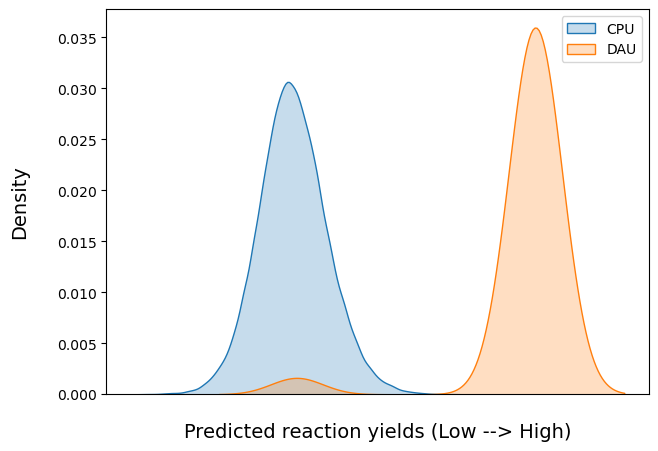

In [31]:
plt.figure(figsize=(7, 5))
sns.kdeplot(cpu_yields, shade=True, label="CPU")
sns.kdeplot(dau_yields, shade=True, label="DAU")
plt.xlabel("Predicted reaction yields (Low --> High)", labelpad=20, fontsize=14)
plt.ylabel("Density", labelpad=20, fontsize=14)
plt.legend(loc="best")
plt.xticks([])
plt.savefig("density_plot.svg", dpi=500, bbox_inches="tight")
plt.savefig("density_plot.png", dpi=500, bbox_inches="tight")
plt.show()